## Imports and getting the data

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, AutoRegResultsWrapper
from typing import Any
from matplotlib.figure import Figure
from matplotlib.axes._axes import Axes
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from xgboost import XGBRegressor

DATA_PATH = "/Users/wojtekurbanski/WBS_DSAI/ML/TimeSeries/project/data/air-quality-london-monthly-averages.csv"
df = pd.read_csv(DATA_PATH)

time_series_df = df[['Month','London Mean Roadside:Nitrogen Dioxide (ug/m3)']]
time_series_df.loc[:, "Month"] = pd.to_datetime(time_series_df["Month"], format='%b-%y')

time_series_df['Month'].duplicated().sum() #1 duplicate
# Show all rows with duplicated 'Month' values
dupes = time_series_df[time_series_df["Month"].duplicated(keep=False)]
print(dupes)
# Drop duplicate months to avoid reindex error
time_series_df = time_series_df.drop_duplicates(subset="Month")

time_series_df["Month"] = pd.to_datetime(time_series_df["Month"])
time_series = time_series_df.set_index("Month")
time_series = time_series.asfreq('MS')  # Set frequency to Month Start
time_series: pd.DataFrame = time_series.sort_index()

time_series.isnull().sum() #2
time_series.isnull().any(axis=1).sum() #2 missing values
# Show all rows with any missing value
missing_rows = time_series[time_series.isnull().any(axis=1)]

time_series = time_series.interpolate()

earliest_date: str = time_series.index.min()
latest_date: str = time_series.index.max()

print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")

time_series.info()
time_series.describe()


                  Month  London Mean Roadside:Nitrogen Dioxide (ug/m3)
59  2012-12-01 00:00:00                                           63.9
71  2012-12-01 00:00:00                                           57.9
Earliest date: 2008-01-01 00:00:00
Latest date: 2019-08-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2008-01-01 to 2019-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   London Mean Roadside:Nitrogen Dioxide (ug/m3)  140 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


,London Mean Roadside:Nitrogen Dioxide (ug/m3)
count,140.000000
mean,55.079643
std,8.405058
min,34.900000
25%,48.675000
50%,55.500000
75%,60.250000
max,75.900000


## Plotting Time series

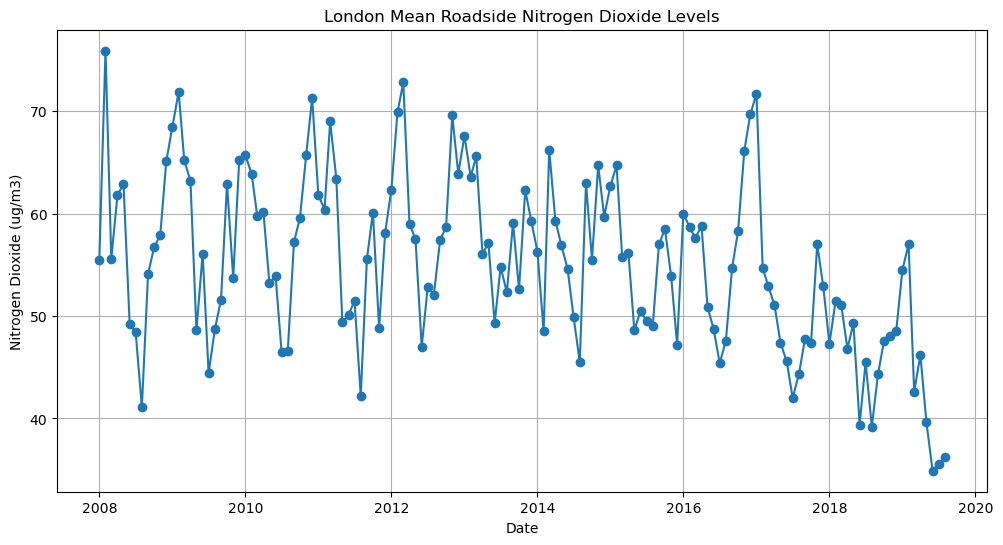

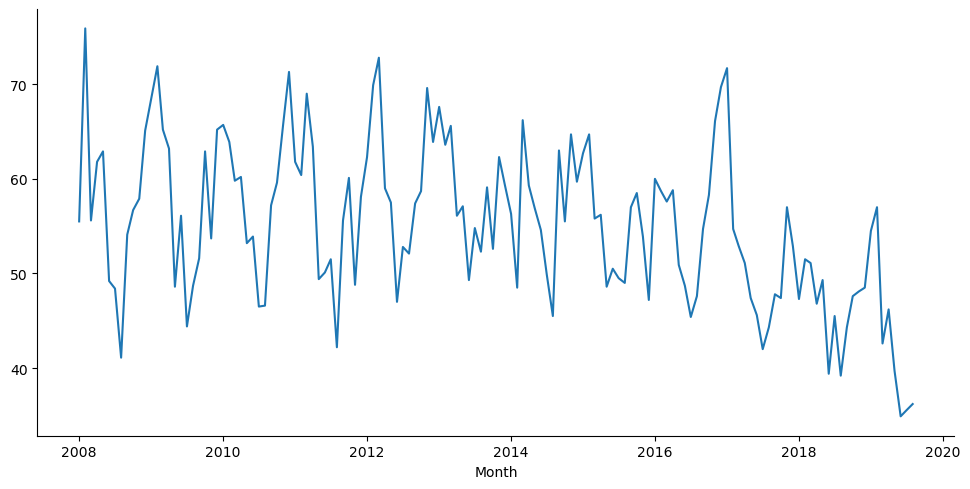

In [114]:
## Plotting Time series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], marker='o')
plt.title('London Mean Roadside Nitrogen Dioxide Levels')
plt.xlabel('Date')
plt.ylabel('Nitrogen Dioxide (ug/m3)')
plt.grid()
plt.show()

sns.relplot(
      kind="line",
      data=time_series,
      aspect=2,
      legend=False
  )


## Decomposition

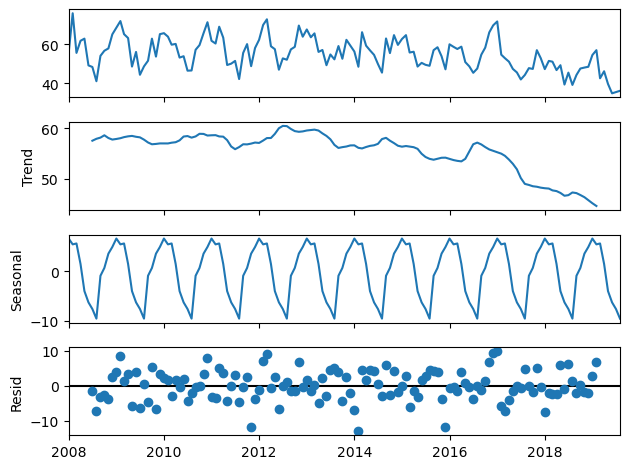

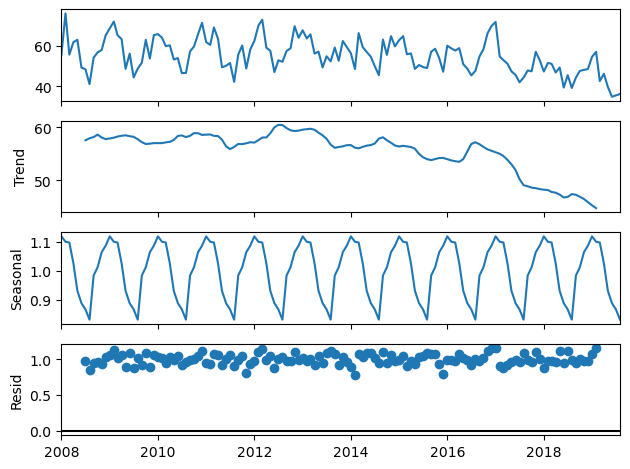

In [115]:
decomposition_add: DecomposeResult = seasonal_decompose(
    time_series,
    model="additive"
)

decomposition_mlt: DecomposeResult = seasonal_decompose(
    time_series,
    model="multiplicative"
)

decomposition_add.plot();
decomposition_mlt.plot();

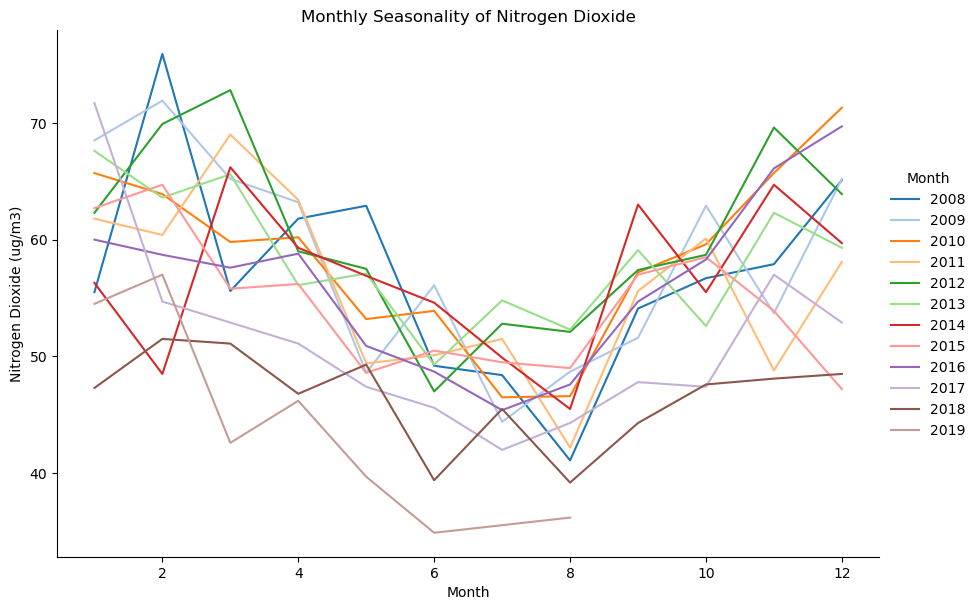

In [206]:
(
    sns.relplot(
        kind="line",
        data=time_series,
        x=time_series.index.month,
        y="London Mean Roadside:Nitrogen Dioxide (ug/m3)",
        hue=time_series.index.year,
        palette="tab20",
        height=6,
        aspect=1.5
    ).set(
        title="Monthly Seasonality of Nitrogen Dioxide",
        xlabel="Month",
        ylabel="Nitrogen Dioxide (ug/m3)"
    )
);

## Train, test split

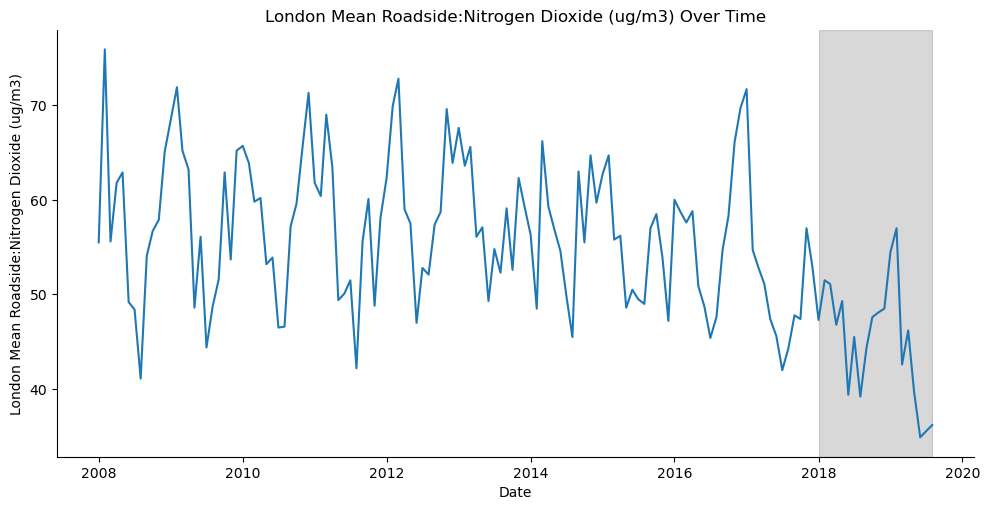

In [117]:
# Plot the data
g: sns.FacetGrid = sns.relplot(kind="line",
                               data=time_series,
                               aspect=2,
                               legend=False)

# Customise labels and title
g.set_axis_labels("Date", "London Mean Roadside:Nitrogen Dioxide (ug/m3)")
g.set(title="London Mean Roadside:Nitrogen Dioxide (ug/m3) Over Time")

# Highlight the last 7 days
last_prediction_date: pd.Timestamp = time_series.index.max()
first_prediction_date: pd.Timestamp = last_prediction_date - pd.Timedelta(weeks=82)
g.ax.axvspan(first_prediction_date,
             last_prediction_date,
             color="grey",
             alpha=0.3);

train: pd.DataFrame = time_series.loc[time_series.index < first_prediction_date]
test: pd.DataFrame = time_series.loc[time_series.index >= first_prediction_date]

## Decomposition of train data shows the trend, seasonality, and residuals don't differ from original data

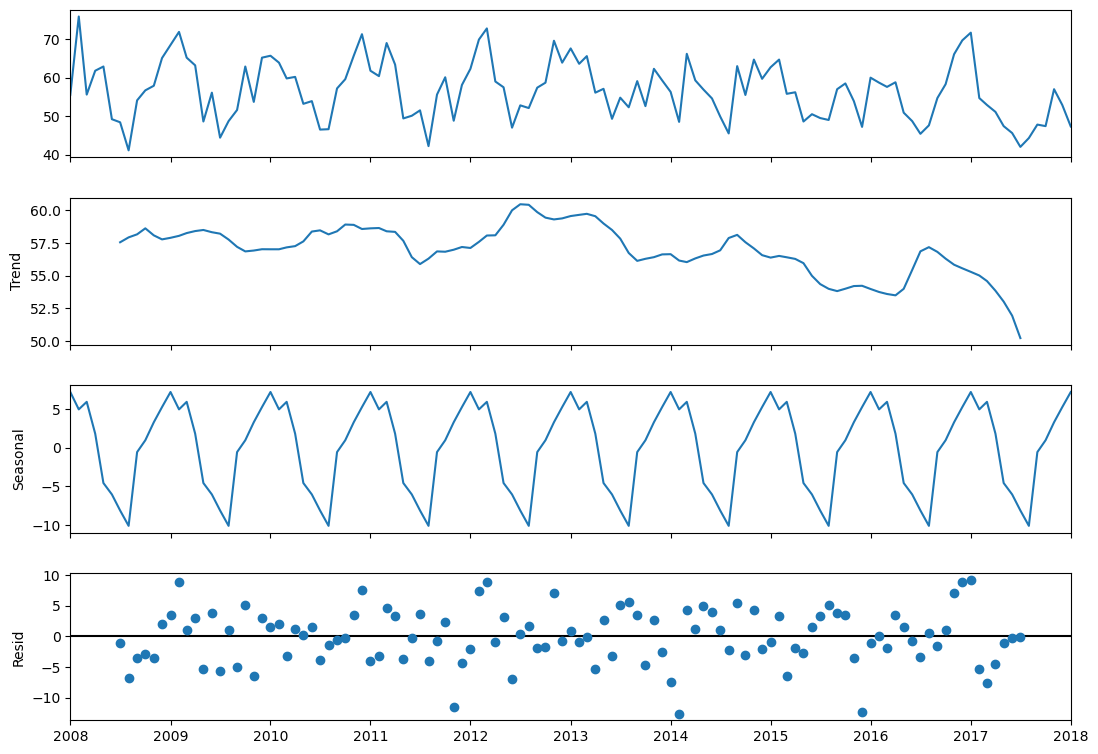

In [118]:
decomposition: DecomposeResult = seasonal_decompose(
    train,
    model="additive"
)

decomposition.plot().set_size_inches(12, 8);

## Baseline naive forecast

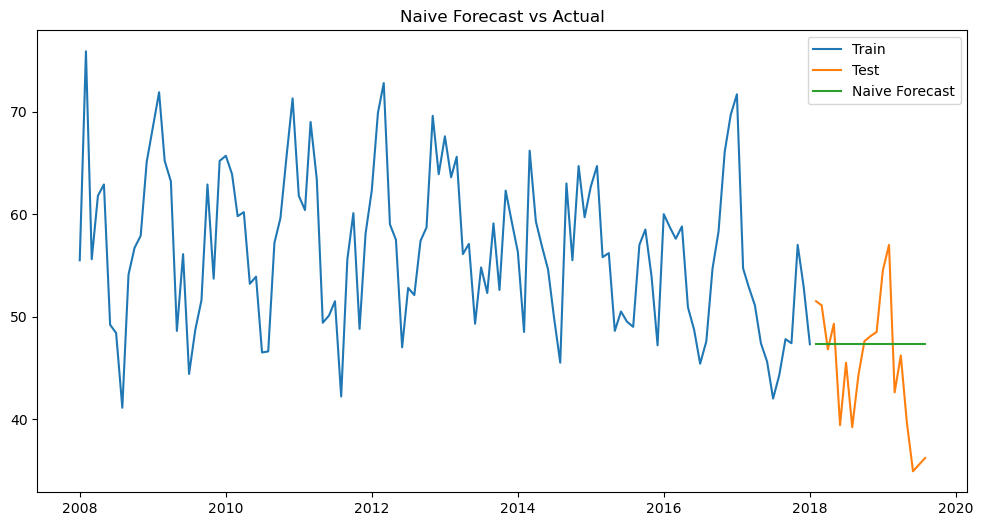

Naive MAE: 5.218421052631578
Naive MSE: 6.572600622840887
Naive MAPE: 0.12576722387452302


In [119]:
# Baseline naive forecast
naive_forecast: pd.Series = test.copy()
naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"] = train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"].iloc[-1]
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Train")
plt.plot(test.index, test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Test")
plt.plot(naive_forecast.index, naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Naive Forecast")
plt.legend()
plt.title("Naive Forecast vs Actual")
plt.show()

# Naive forecast scores
naive_mae: float = mean_absolute_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Naive MAE: {naive_mae}")
naive_mse: float = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Naive MSE: {naive_mse}")
naive_mape: float = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Naive MAPE: {naive_mape}")

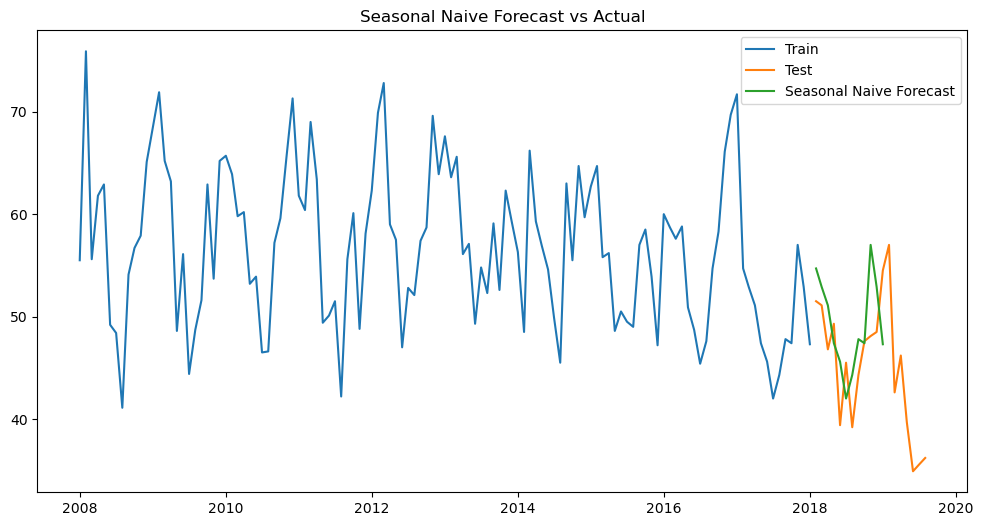

,London Mean Roadside:Nitrogen Dioxide (ug/m3)
Month,
2019-02-01,NaN
2019-03-01,NaN
2019-04-01,NaN
2019-05-01,NaN
2019-06-01,NaN
2019-07-01,NaN
2019-08-01,NaN


In [120]:
# Seasonal Naive Forecast
# take values from previous season / year
seasonal_naive_forecast: pd.Series = test.copy()
# Seasonal Naive Forecast: use previous year's value for each test month
for idx in test.index:
    prev_year = idx - pd.DateOffset(years=1)
    if prev_year in train.index:
        seasonal_naive_forecast.loc[idx, "London Mean Roadside:Nitrogen Dioxide (ug/m3)"] = train.loc[prev_year, "London Mean Roadside:Nitrogen Dioxide (ug/m3)"]
    else:
        seasonal_naive_forecast.loc[idx, "London Mean Roadside:Nitrogen Dioxide (ug/m3)"] = np.nan
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Train")
plt.plot(test.index, test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Test")
plt.plot(seasonal_naive_forecast.index, seasonal_naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Seasonal Naive Forecast")
plt.legend()
plt.title("Seasonal Naive Forecast vs Actual")
plt.show()
seasonal_naive_forecast[seasonal_naive_forecast.isnull().any(axis=1)]
# Seasonal naive forecast scores
# seasonal_naive_mae: float = mean_absolute_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], seasonal_naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
# print(f"Seasonal Naive MAE: {seasonal_naive_mae}")
# seasonal_naive_mse: float = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], seasonal_naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
# print(f"Seasonal Naive MSE: {seasonal_naive_mse}")
# seasonal_naive_mape: float = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], seasonal_naive_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
# print(f"Seasonal Naive MAPE: {seasonal_naive_mape}")

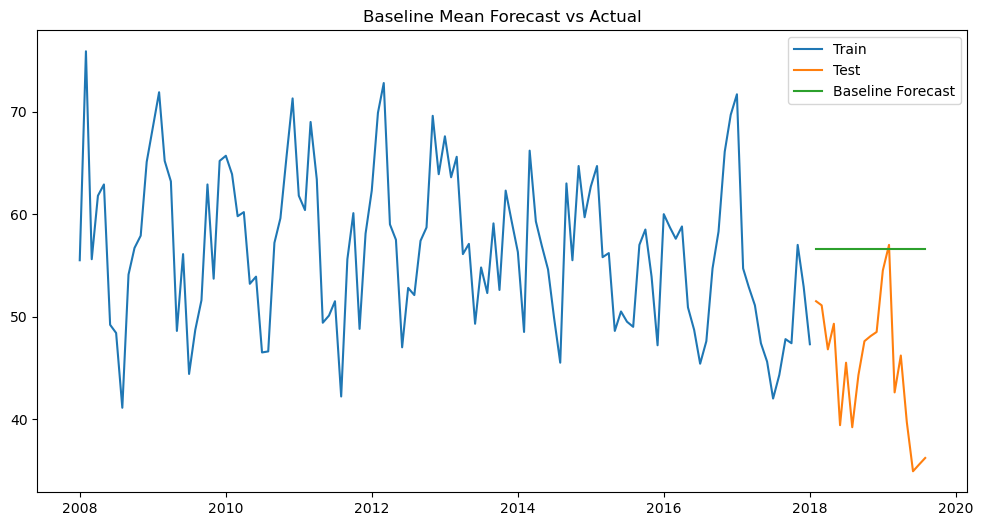

Baseline MAE: 11.52085689430187
Baseline MSE: 13.055757649612136
Baseline MAPE: 0.2798092471330181


In [121]:
# Baseline prediction with mean
train_mean: float = train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"].mean()
baseline_forecast: pd.Series = test.copy()
baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"] = train_mean
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Train")
plt.plot(test.index, test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Test")
plt.plot(baseline_forecast.index, baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Baseline Forecast")
plt.legend()
plt.title("Baseline Mean Forecast vs Actual")
plt.show()

# Baseline forecast scores
baseline_mae: float = mean_absolute_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Baseline MAE: {baseline_mae}")
baseline_mse: float = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Baseline MSE: {baseline_mse}")
baseline_mape: float = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Baseline MAPE: {baseline_mape}")

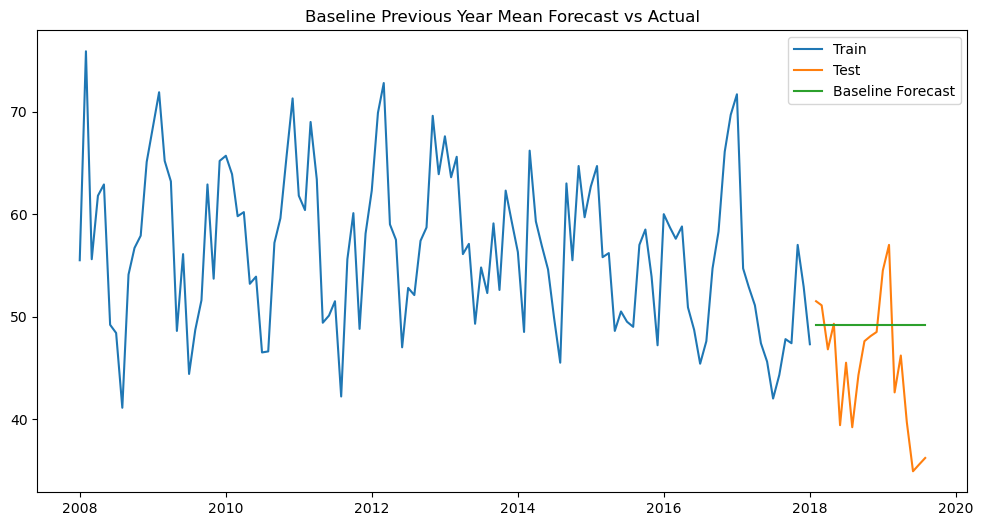

Baseline MAE: 5.876315789473678
Baseline MSE: 7.413439076931052
Baseline MAPE: 0.14462646400225768


In [122]:
# Previous year mean
previous_year_mean: float = train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"].tail(12).mean()

baseline_forecast: pd.Series = test.copy()
baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"] = previous_year_mean

plt.figure(figsize=(12, 6))
plt.plot(train.index, train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Train")
plt.plot(test.index, test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Test")
plt.plot(baseline_forecast.index, baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], label="Baseline Forecast")
plt.legend()
plt.title("Baseline Previous Year Mean Forecast vs Actual")
plt.show()

# Baseline forecast scores
baseline_mae: float = mean_absolute_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Baseline MAE: {baseline_mae}")
baseline_mse: float = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Baseline MSE: {baseline_mse}")
baseline_mape: float = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], baseline_forecast["London Mean Roadside:Nitrogen Dioxide (ug/m3)"])
print(f"Baseline MAPE: {baseline_mape}")

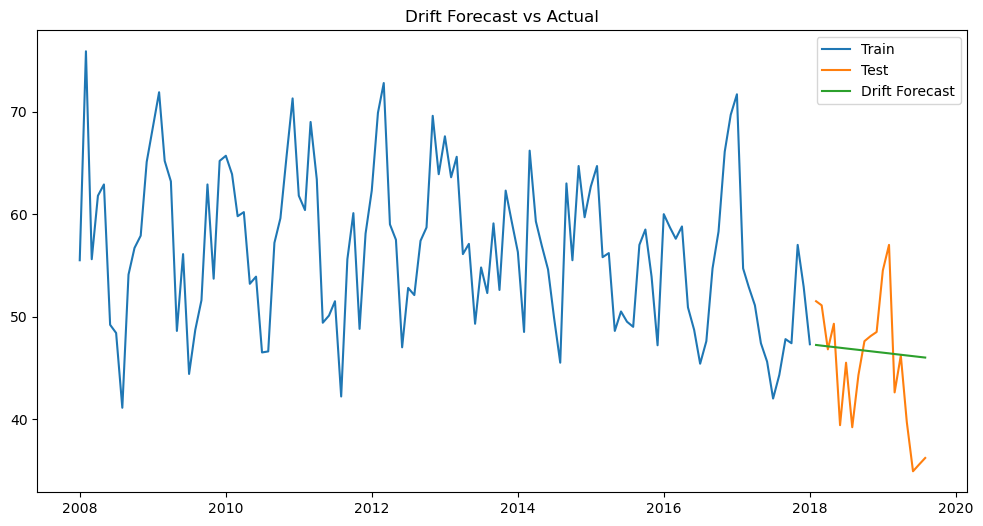

Drift MAE: 4.981052631578948
Drift MSE: 6.2188932327975905
Drift MAPE: 0.1184126145916807


In [123]:
# Trend-Adjusted Naive (Drift Method)
def drift_forecast(train: pd.DataFrame, test: pd.DataFrame) -> np.ndarray:
    T: int = len(train)
    y_T: float = train['London Mean Roadside:Nitrogen Dioxide (ug/m3)'].iloc[-1]
    y_1: float = train['London Mean Roadside:Nitrogen Dioxide (ug/m3)'].iloc[0]

    # Calculate slope
    slope: float = (y_T - y_1) / (T - 1)

    # Forecast horizon
    h: np.ndarray = np.arange(1, len(test) + 1)

    # Generate forecasts
    forecast: np.ndarray = y_T + slope * h
    return forecast

# Generate Drift Forecasts
forecast: np.ndarray = drift_forecast(train, test)

#plot drifted forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], label="Train")
plt.plot(test.index, test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], label="Test")
plt.plot(test.index, forecast, label="Drift Forecast")
plt.legend()
plt.title("Drift Forecast vs Actual")
plt.show()

#scores
drift_mae: float = mean_absolute_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], forecast) 
drift_mse: float = root_mean_squared_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], forecast)
drift_mape: float = mean_absolute_percentage_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], forecast)
print(f"Drift MAE: {drift_mae}")
print(f"Drift MSE: {drift_mse}")
print(f"Drift MAPE: {drift_mape}")


## 2.&nbsp; Augmented Dickey-Fuller (ADF) test

In [124]:
# ## 2.&nbsp; Augmented Dickey-Fuller (ADF) test
adf_result: Any = adfuller(time_series['London Mean Roadside:Nitrogen Dioxide (ug/m3)'])

# Print the ADF statistic and the p-value
print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

# Print the critical values for different confidence levels
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.3f}")

#results:
# ADF Statistic: 0.420454
# p-value: 0.982244
# Critical Values:
# 	1%: -3.483
# 	5%: -2.884
# 	10%: -2.579
# Interpretation:
# Since the ADF statistic is greater than the critical values, we fail to reject the null hypothesis.
# This suggests that the time series is non-stationary.
# This means we'll need to transform the data to achieve stationarity before moving forward.

if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary and requires differencing.")

ADF Statistic: 0.420454
p-value: 0.982244
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579
The time series is non-stationary and requires differencing.


## 3.&nbsp; Autocorrelation Function (ACF) plot

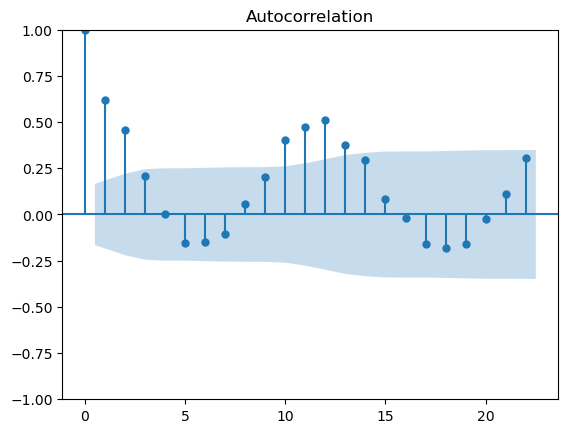

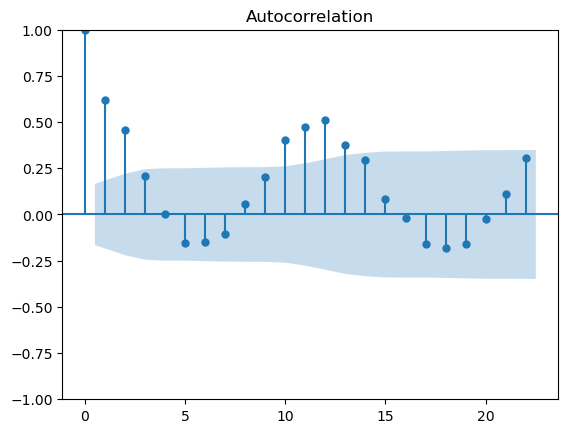

In [125]:
plot_acf(time_series['London Mean Roadside:Nitrogen Dioxide (ug/m3)'])

# Differencing

            London Mean Roadside:Nitrogen Dioxide (ug/m3)  \
Month                                                       
2008-01-01                                           55.5   
2008-02-01                                           75.9   
2008-03-01                                           55.6   
2008-04-01                                           61.8   
2008-05-01                                           62.9   

            London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff  
Month                                                           
2008-01-01                                                NaN   
2008-02-01                                               20.4   
2008-03-01                                              -20.3   
2008-04-01                                                6.2   
2008-05-01                                                1.1   


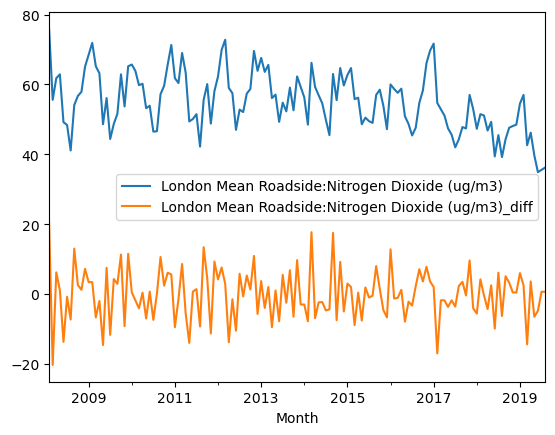

In [126]:
time_series_diff: pd.DataFrame = time_series.copy()
time_series_diff['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'] = time_series_diff['London Mean Roadside:Nitrogen Dioxide (ug/m3)'].diff()
print(time_series_diff.head())
time_series_diff: pd.DataFrame = time_series_diff.dropna()
time_series_diff.plot();

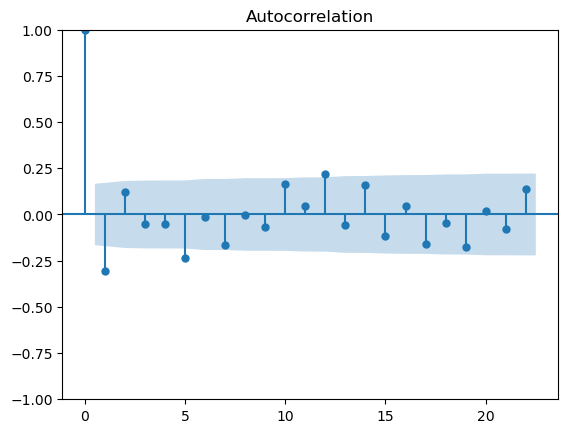

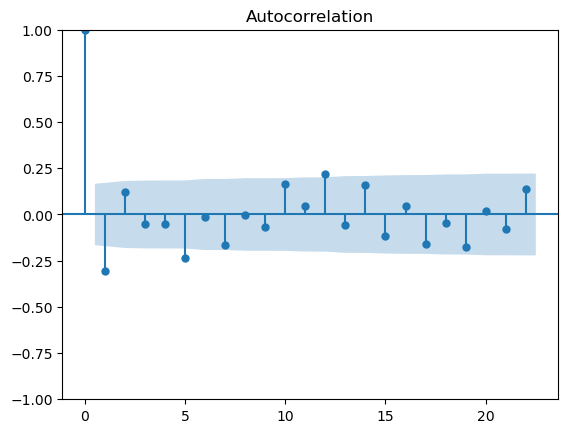

In [127]:
plot_acf(time_series_diff['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'])

In [128]:
#Check adfuller test on differenced series
adf_result_diff: Any = adfuller(time_series_diff['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'])

# Print the ADF statistic and the p-value
print("ADF Statistic: %f" % adf_result_diff[0])
print("p-value: %f" % adf_result_diff[1])

# Print the critical values for different confidence levels
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"\t{key}: {value:.3f}")

# Interpretation
if adf_result_diff[1] < 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is non-stationary.")

ADF Statistic: -8.375562
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
The differenced time series is stationary.


In [129]:
# Split diff ts into train and test sets
train_size = int(len(time_series_diff) * 0.8)
train, test = time_series_diff[:train_size], time_series_diff[train_size:]

# Moving average forecast (MA)

In [130]:
# # Moving average forecast (MA)
def moving_average_forecast_data_leak(
    train_series: pd.Series,
    test_series: pd.Series,
    window_size: int
) -> list[float]:
    # Convert the training series into a list to maintain a history of observations
    history = list(train_series)
    # Initialise an empty list to store the forecasted values
    predictions: list[float] = []

    # Loop over each time point in the test series
    for t in range(len(test_series)):
        # Check if the history has enough data points to use the full window size
        if len(history) >= window_size:
            # Calculate the average of the last 'window_size' observations
            yhat = sum(history[-window_size:]) / window_size
        else:
            # If not enough data, calculate the average of all available history
            yhat = sum(history) / len(history)
        # Append the forecasted value to the predictions list
        predictions.append(yhat)
        # Add the next test value to history to move to the next day and use the latest data for the next prediction
        history.append(test_series.iloc[t])

    # Return the list of forecasted values
    return predictions

#Data leakage introduced in this function from above because we use test values to update the history!!!!

def moving_average_forecast(
    train_series: pd.Series,
    test_series: pd.Series,
    window_size: int
) -> list[float]:
    # Convert the training series into a list to maintain a history of observations
    history = list(train_series)
    # Initialise an empty list to store the forecasted values
    predictions: list[float] = []

    # Loop over each time point in the test series
    for t in range(len(test_series)):
        # Check if the history has enough data points to use the full window size
        if len(history) >= window_size:
            # Calculate the average of the last 'window_size' observations
            yhat = sum(history[-window_size:]) / window_size
        else:
            # If not enough data, calculate the average of all available history
            yhat = sum(history) / len(history)
        # Append the forecasted value to the predictions list
        predictions.append(yhat)
        # Add the next test value to history to move to the next day and use the latest data for the next prediction
        history.append(yhat)

    # Return the list of forecasted values
    return predictions


MA(3) maE: 5.396886812105322
MA(3) MSE: 50.7909810696397
MA(3) MAPE: 1.0969012507060902


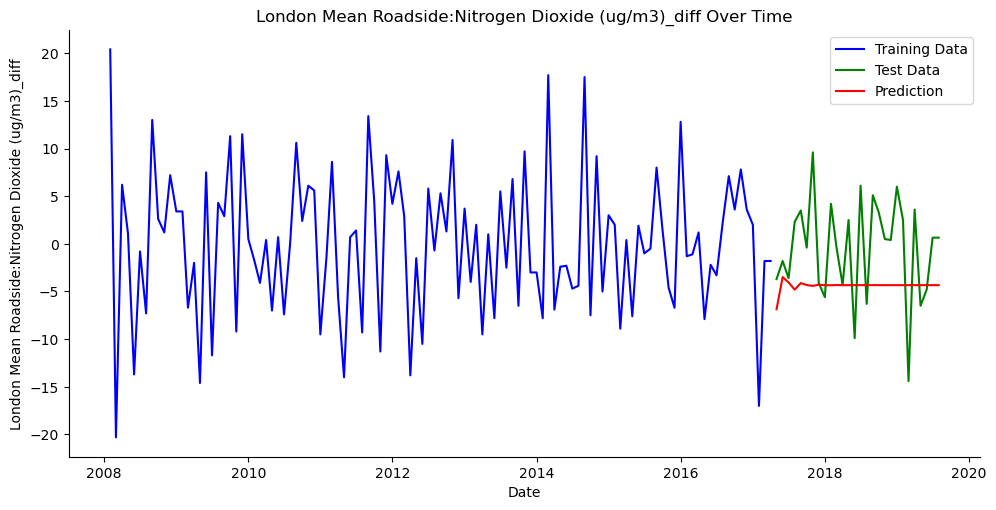

In [131]:
window_size = 3
predictions_ma3: list[float] = moving_average_forecast(train['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'],
                                                       test['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'],
                                                       window_size)

# Plot the Train Data
g: sns.FacetGrid = sns.relplot(kind='line',
                               data=train,
                               x=train.index,
                               y='London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff',
                               color='blue',
                               label='Training Data',
                               aspect=2)

# Plot the Test Data on the same axis
sns.lineplot(data=test,
             x=test.index,
             y='London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff',
             color='green',
             label='Test Data',
             ax=g.ax)

# Plot the Predictions on the same axis
sns.lineplot(data=test,
             x=test.index,
             y=predictions_ma3,
             color='red',
             label='Prediction',
             ax=g.ax)

# Customise labels and title
g.set_axis_labels("Date", "London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff")
g.set(title="London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff Over Time");

#score moving average
ma3_mae = mean_absolute_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'], predictions_ma3)
print(f'MA(3) maE: {ma3_mae}')
ma3_mse = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions_ma3)
print(f"MA(3) MSE: {ma3_mse}")
ma3_mape = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions_ma3)
print(f"MA(3) MAPE: {ma3_mape}")

MA(7) maE: 4.845203644075162
MA(7) MSE: 48.83785058832589
MA(7) MAPE: 1.0538207921198843


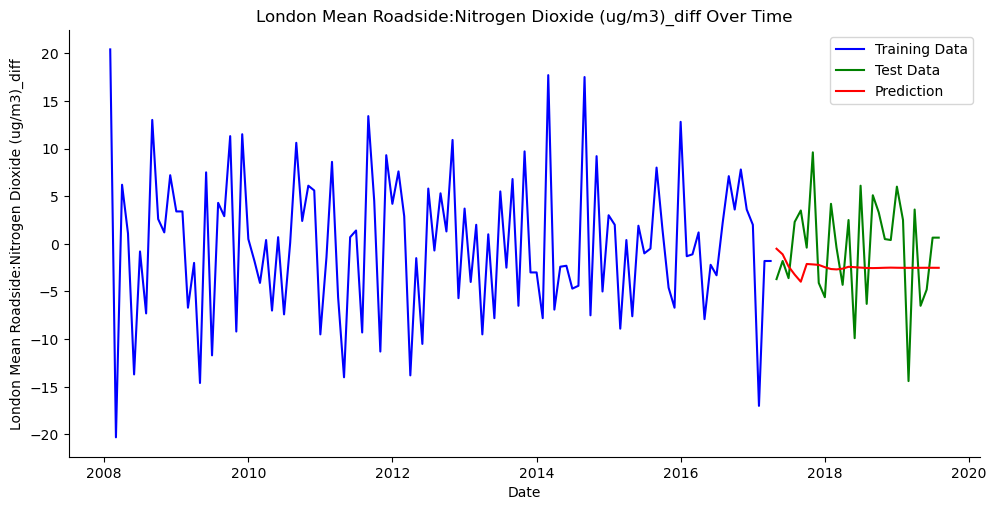

In [132]:
window_size = 7
predictions_ma7: list[float] = moving_average_forecast(train['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'],
                                                           test['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'],
                                                           window_size)
# Plot the Train Data
g: sns.FacetGrid = sns.relplot(kind='line',
                               data=train,
                               x=train.index,
                               y='London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff',
                               color='blue',
                               label='Training Data',
                               aspect=2)

# Plot the Test Data on the same axis
sns.lineplot(data=test,
             x=test.index,
             y='London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff',
             color='green',
             label='Test Data',
             ax=g.ax)

# Plot the Predictions on the same axis
sns.lineplot(data=test,
             x=test.index,
             y=predictions_ma7,
             color='red',
             label='Prediction',
             ax=g.ax)

# Customise labels and title
g.set_axis_labels("Date", "London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff")
g.set(title="London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff Over Time");

#score moving average
ma7_mae = mean_absolute_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'], predictions_ma7)
print(f'MA(7) maE: {ma7_mae}')
ma7_mse = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions_ma7)
print(f"MA(7) MSE: {ma7_mse}")
ma7_mape = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions_ma7)
print(f"MA(7) MAPE: {ma7_mape}")


MA(12) maE: 4.2696879676178074
MA(12) MSE: 47.15407150915716
MA(12) MAPE: 1.015700481376119


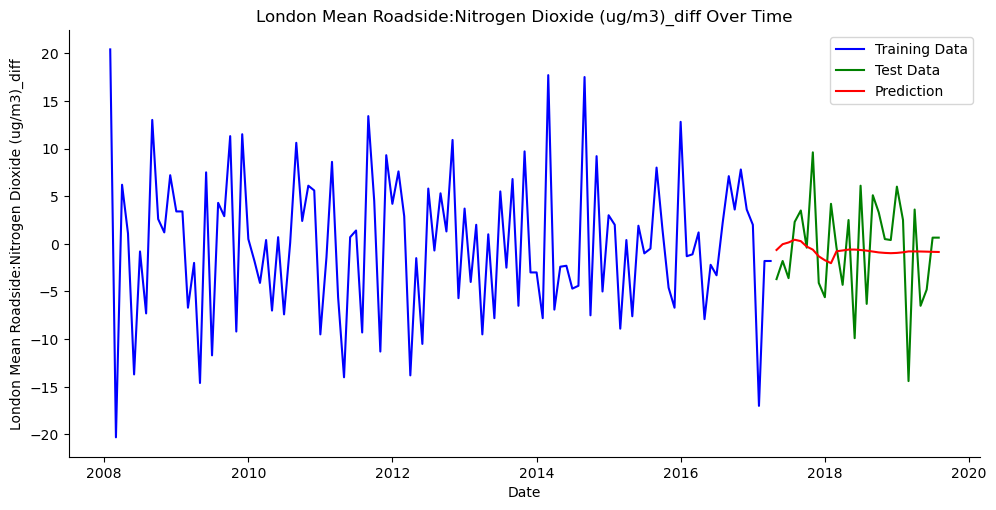

In [133]:
window_size = 12
predictions_ma12: list[float] = moving_average_forecast(train['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'],
                                                           test['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'],
                                                           window_size)
# Plot the Train Data
g: sns.FacetGrid = sns.relplot(kind='line',
                               data=train,
                               x=train.index,
                               y='London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff',
                               color='blue',
                               label='Training Data',
                               aspect=2)

# Plot the Test Data on the same axis
sns.lineplot(data=test,
             x=test.index,
             y='London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff',
             color='green',
             label='Test Data',
             ax=g.ax)

# Plot the Predictions on the same axis
sns.lineplot(data=test,
             x=test.index,
             y=predictions_ma12,
             color='red',
             label='Prediction',
             ax=g.ax)

# Customise labels and title
g.set_axis_labels("Date", "London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff")
g.set(title="London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff Over Time");

#score moving average
ma12_mae = mean_absolute_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'], predictions_ma12)
print(f'MA(12) maE: {ma12_mae}')
ma12_mse = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions_ma12)
print(f"MA(12) MSE: {ma12_mse}")
ma12_mape = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions_ma12)
print(f"MA(12) MAPE: {ma12_mape}")


# Autoregressive Models

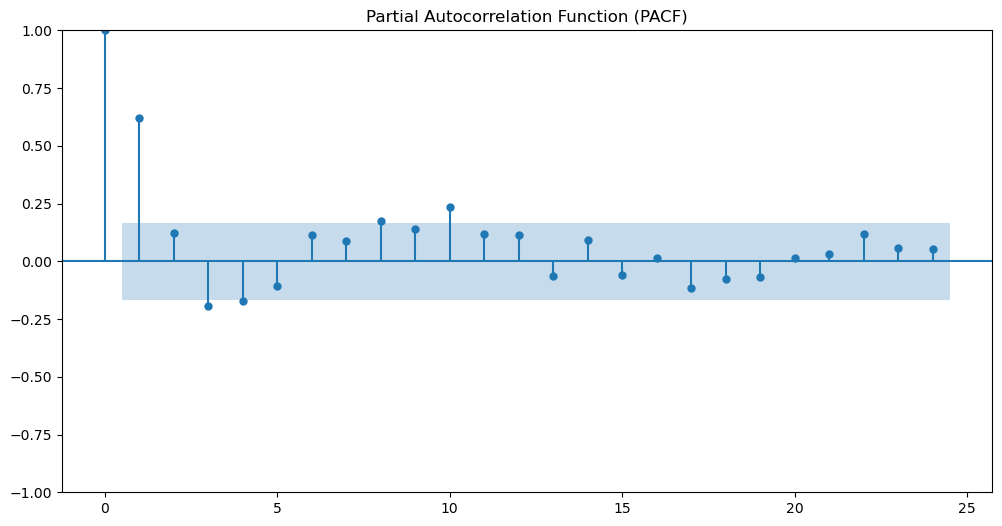

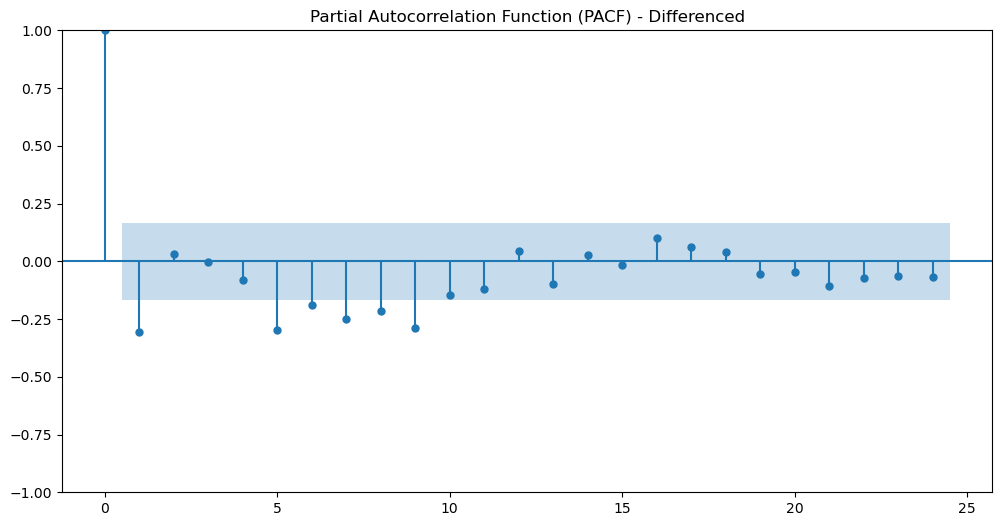

In [134]:
# Plot PACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(time_series['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], lags=24, ax=ax)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

# Plot PACF for diffed data
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(time_series_diff['London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff'], lags=24, ax=ax)
plt.title("Partial Autocorrelation Function (PACF) - Differenced")
plt.show()


# AR model

In [135]:
p: int = 1
ar_model: AutoRegResultsWrapper = AutoReg(train["London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff"], lags=p).fit()

predictions_from: int = len(train)
predictions_to: int = len(train) + len(test) - 1

predictions_diff: Any = ar_model.predict(start=predictions_from, end=predictions_to)

print(ar_model.summary())

                                            AutoReg Model Results                                             
Dep. Variable:     London Mean Roadside:Nitrogen Dioxide (ug/m3)_diff   No. Observations:                  111
Model:                                                     AutoReg(1)   Log Likelihood                -369.460
Method:                                               Conditional MLE   S.D. of innovations              6.957
Date:                                                Tue, 02 Sep 2025   AIC                            744.919
Time:                                                        11:22:11   BIC                            753.021
Sample:                                                    03-01-2008   HQIC                           748.205
                                                         - 04-01-2017                                         
                                                            coef    std err          z      P>|z|      [0.025   

In [136]:
# we need to invert the differencing to obtain actual price predictions.
last_train_value = train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"].iloc[-1]
predictions: list[float] = []
current_value: float = last_train_value

for diff_value in predictions_diff:
    current_value += diff_value
    predictions.append(current_value)

predictions: pd.Series = pd.Series(predictions, index=test.index)

MA(12) MAE: 4.978658983940558
MA(12) MSE: 6.131404963755108
MA(12) MAPE: 0.11645712040687718


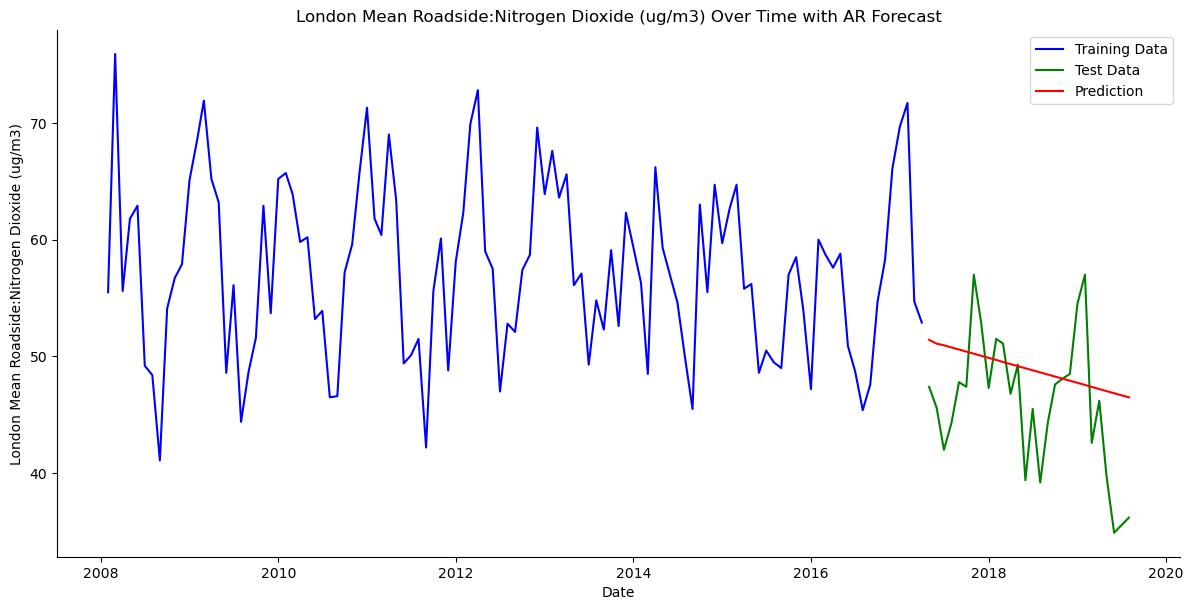

In [137]:
train: pd.DataFrame
test: pd.DataFrame
predictions: pd.Series

# Plot the Train Data
g: sns.FacetGrid = sns.relplot(kind="line",
                               data=time_series.head(len(train)),
                               x=train.index,
                               y="London Mean Roadside:Nitrogen Dioxide (ug/m3)",
                               color="blue",
                               label="Training Data",
                               height=6,
                               aspect=2)

# Plot the Test Data on the same axis
sns.lineplot(data=time_series.tail(len(test)),
             x=test.index,
             y="London Mean Roadside:Nitrogen Dioxide (ug/m3)",
             color="green",
             label="Test Data",
             ax=g.ax)

# Plot the Predictions on the same axis
sns.lineplot(data=test,
             x=test.index,
             y=predictions,
             color="red",
             label="Prediction",
             ax=g.ax)

# Customise labels and title
g.set_axis_labels("Date", "London Mean Roadside:Nitrogen Dioxide (ug/m3)")
g.set(title="London Mean Roadside:Nitrogen Dioxide (ug/m3) Over Time with AR Forecast");

# AR model scores
ar_mae = mean_absolute_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], predictions)
print(f'MA(12) MAE: {ar_mae}')
ar_mse = root_mean_squared_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions)
print(f"MA(12) MSE: {ar_mse}")
ar_mape = mean_absolute_percentage_error(test["London Mean Roadside:Nitrogen Dioxide (ug/m3)"], predictions)
print(f"MA(12) MAPE: {ar_mape}")

## ARIMA

In [138]:
d: int = 1  # since we know from our previous notebooks that the data should be differenced once
p: int = 1  # PACF cuts off after lag 1
q: int = 1  # ACF cuts off after lag 1

# Define the model
arima_model: ARIMA = ARIMA(train["London Mean Roadside:Nitrogen Dioxide (ug/m3)"],
                           order=(p, d, q))  # remember, we set p, d, & q earlier with the ACF and PACF plots

# Fit the model
arima_fit: ARIMAResults = arima_model.fit()

arima_forecast: pd.Series = arima_fit.forecast(steps=len(test))
arima_predictions: pd.DataFrame = pd.DataFrame(arima_forecast, index=test.index)
arima_predictions.head()

,predicted_mean
Month,
2017-05-01,51.910515
2017-06-01,51.427617
2017-07-01,51.715323
2017-08-01,51.543910
2017-09-01,51.646037


In [139]:
# we'll use this code again later, so let's make it a function to save repetition
def plot_forecasts(
    test: pd.DataFrame,
    predictions: pd.DataFrame,
    title: str
) -> None:

  g: sns.FacetGrid = sns.relplot(kind='line',
                                 data=test,
                                 x=test.index,
                                 y='London Mean Roadside:Nitrogen Dioxide (ug/m3)',
                                 color='green',
                                 label='Test Data',
                                 aspect=1.5)

  # Plot the Predictions on the same axis
  sns.lineplot(data=predictions,
               x=predictions.index,
               y='predicted_mean',
               color='red',
               label='Prediction',
               ax=g.ax)

  # Customise labels and title
  g.set_axis_labels("Date", "Nitrogen Dioxide (ug/m3)")
  g.set(title=title)

  # Rotate x-axis labels
  g.ax.tick_params(axis='x', rotation=25)

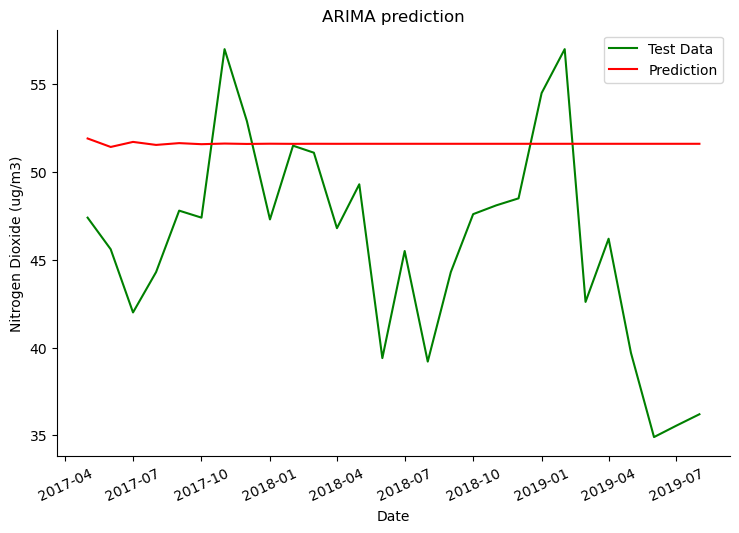

In [140]:
plot_forecasts(test, arima_predictions, "ARIMA prediction")

In [141]:
def evaluate_model(
    test: pd.DataFrame,
    predictions: pd.DataFrame,
    model_name: str = "Model"
) -> dict[str, float]:

    mae: float = mean_absolute_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], predictions['predicted_mean'])
    rmse: float = root_mean_squared_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], predictions['predicted_mean'])
    mape: float = mean_absolute_percentage_error(test['London Mean Roadside:Nitrogen Dioxide (ug/m3)'], predictions['predicted_mean'])

    print(f"Evaluation Metrics for {model_name} Forecast:")
    print(f"\t Mean Absolute Error (MAE): {mae:.2f}")
    print(f"\t Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"\t Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [142]:
arima_metrics: dict[str, float] = evaluate_model(test, arima_predictions, 'ARIMA')

Evaluation Metrics for ARIMA Forecast:
	 Mean Absolute Error (MAE): 6.62
	 Root Mean Squared Error (RMSE): 8.03
	 Mean Absolute Percentage Error (MAPE): 15.85%


## SARIMA

In [143]:
s: int = 12  # we know the seasonality is yearly with monthly data, so 12 months
P: int = 3
Q: int = 5
D: int = 1 # Seasonal differencing helps in stabilising the mean of a time series by removing seasonal effects. Typically, `D` is set to 1 if seasonality is present.


In [144]:
train: pd.DataFrame
p: int
d: int
q: int
P: int
D: int
Q: int
s: int

# Define the SARIMA model
sarima_model: SARIMAX = SARIMAX(train['London Mean Roadside:Nitrogen Dioxide (ug/m3)'],
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s))

# Fit the model
sarima_fit: SARIMAXResults = sarima_model.fit()

/opt/miniconda3/envs/time_series/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/miniconda3/envs/time_series/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [145]:
sarima_forecast: pd.Series = sarima_fit.forecast(steps=len(test))
sarima_predictions: pd.DataFrame = pd.DataFrame(sarima_forecast, index=test.index)
sarima_predictions.head()

,predicted_mean
Month,
2017-05-01,48.713029
2017-06-01,50.441232
2017-07-01,46.309553
2017-08-01,44.884211
2017-09-01,55.515608


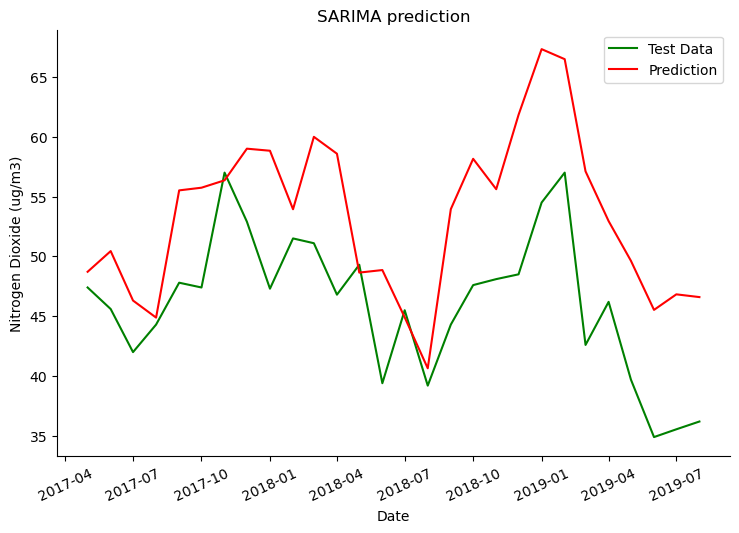

In [146]:
plot_forecasts(test, sarima_predictions, "SARIMA prediction")

In [147]:
sarima_metrics: dict[str, float] = evaluate_model(test, sarima_predictions, 'SARIMA')

Evaluation Metrics for SARIMA Forecast:
	 Mean Absolute Error (MAE): 7.41
	 Root Mean Squared Error (RMSE): 8.57
	 Mean Absolute Percentage Error (MAPE): 16.61%


In [148]:
arima_metrics: dict[str, float]
sarima_metrics: dict[str, float]

evaluation_data: dict[str, list[str | float]] = {
    "Metric": ["MAE", "RMSE", "MAPE"],
    "ARIMA": [arima_metrics["MAE"], arima_metrics["RMSE"], f"{arima_metrics['MAPE'] * 100:.2f}%"],
    "SARIMA": [sarima_metrics["MAE"], sarima_metrics["RMSE"], f"{sarima_metrics['MAPE'] * 100:.2f}%"]
}

evaluation_df: pd.DataFrame = pd.DataFrame(evaluation_data)

evaluation_df

,Metric,ARIMA,SARIMA
0,MAE,6.62453,7.409527
1,RMSE,8.033768,8.567708
2,MAPE,15.85%,16.61%


# Time-Based Cross Validation in Time Series Forecasting

In [149]:
def evaluate_forecast(
    y_true: pd.Series,
    y_pred: pd.Series
) -> tuple[float, float, float]:

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return mae, rmse, mape

In [150]:
# Parameters for the sliding window
months_into_the_past: int = 20
months_into_the_future: int = 15

# Perform walk-forward validation using an ARIMA model
def walk_forward_validation(
    data: pd.Series,
    window_size: int = months_into_the_past,
    forecast_horizon: int = months_into_the_future
) -> pd.DataFrame:

    results: list[Dict[str, Any]] = []

    # Move the training and test window forward step by step
    for start in range(0, len(data) - window_size - forecast_horizon, forecast_horizon):
        train = data.iloc[start:start + window_size]
        test = data.iloc[start + window_size:start + window_size + forecast_horizon]

        # Fit ARIMA model to training data
        model = ARIMA(train, order=(1,1,1))
        model_fit = model.fit()

        # Forecast and evaluate against the test data
        forecast = model_fit.forecast(steps=forecast_horizon)
        mae, rmse, mape = evaluate_forecast(test, forecast)

        # Store results for this iteration
        results.append({
            'start': test.index[0],
            'end': test.index[-1],
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        })

    # Return all validation results as a DataFrame
    return pd.DataFrame(results)

# Run walk-forward validation on adjusted closing prices
results_df: pd.DataFrame = walk_forward_validation(time_series)

# Display the first few rows of the results
results_df

/opt/miniconda3/envs/time_series/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/time_series/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/miniconda3/envs/time_series/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/time_series/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

,start,end,mae,rmse,mape
0,2009-09-01,2010-11-01,11.131348,12.691306,0.183013
1,2010-12-01,2012-02-01,8.732779,10.669550,0.167843
2,2012-03-01,2013-05-01,12.794803,14.397471,0.228609
3,2013-06-01,2014-08-01,4.302582,5.257993,0.079939
4,2014-09-01,2015-11-01,9.030650,10.524786,0.152331
5,2015-12-01,2017-02-01,6.491778,7.994629,0.113083
6,2017-03-01,2018-05-01,5.654538,6.466959,0.120800


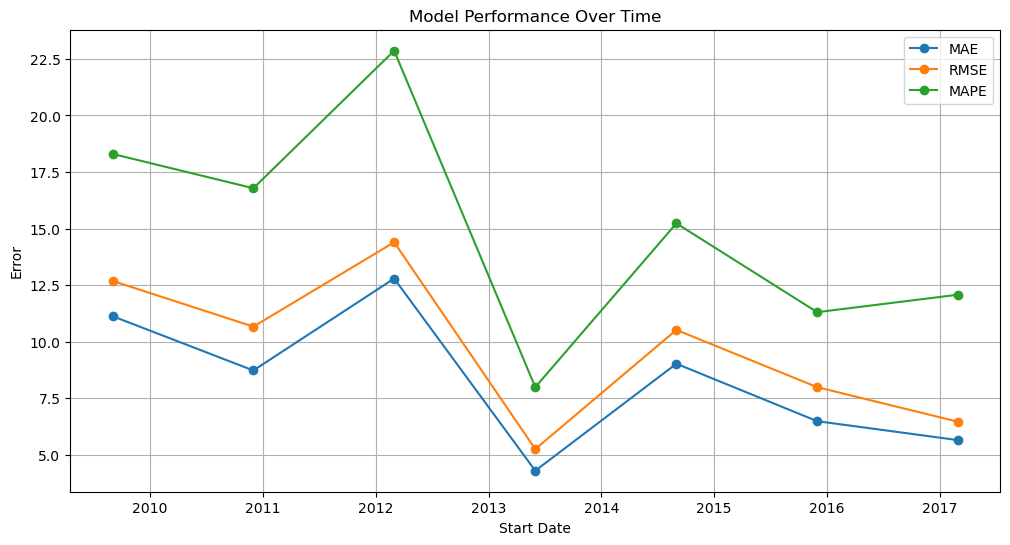

In [151]:
# Visualise Performance Over Time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['start'], results_df['mae'], marker='o', label='MAE')
plt.plot(results_df['start'], results_df['rmse'], marker='o', label='RMSE')
plt.plot(results_df['start'], results_df['mape']*100, marker='o', label='MAPE')
plt.title('Model Performance Over Time')
plt.xlabel('Start Date')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()


# Prophet model

In [152]:
# Rename the columns to 'ds' and 'y' as required by Prophet
df: pd.DataFrame = time_series_df.rename(columns={'Month': 'ds', 'London Mean Roadside:Nitrogen Dioxide (ug/m3)': 'y'})

# Sort by datetime just to ensure it's in order (Prophet prefers chronological order)
df = df.sort_values(by='ds')

# If there are any missing values, drop them (or we could fill them)
df = df.dropna()

# Check the first few rows after renaming
df.head()

,ds,y
0,2008-01-01,55.5
1,2008-02-01,75.9
2,2008-03-01,55.6
3,2008-04-01,61.8
4,2008-05-01,62.9


In [153]:
df: pd.DataFrame

# Define the split point - for example, use 80% of data for training and 20% for testing
split_index: int = int(len(df) * 0.8)
train_df: pd.DataFrame = df.iloc[:split_index].copy()
test_df: pd.DataFrame = df.iloc[split_index:].copy()

print(f"Training period: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}")
print(f"Testing period: {test_df['ds'].min().date()} to {test_df['ds'].max().date()}")
print(f"Training points: {len(train_df)}, Testing points: {len(test_df)}")

Training period: 2008-01-01 to 2017-03-01
Testing period: 2017-04-01 to 2019-08-01
Training points: 110, Testing points: 28


11:22:17 - cmdstanpy - INFO - Chain [1] start processing
11:22:17 - cmdstanpy - INFO - Chain [1] done processing


Test set start date: 2017-04-01 00:00:00
Test set end date: 2019-08-01 00:00:00
Train set start date: 2008-01-01 00:00:00
Train set end date: 2017-03-01 00:00:00
Number of months in the test set range: 28


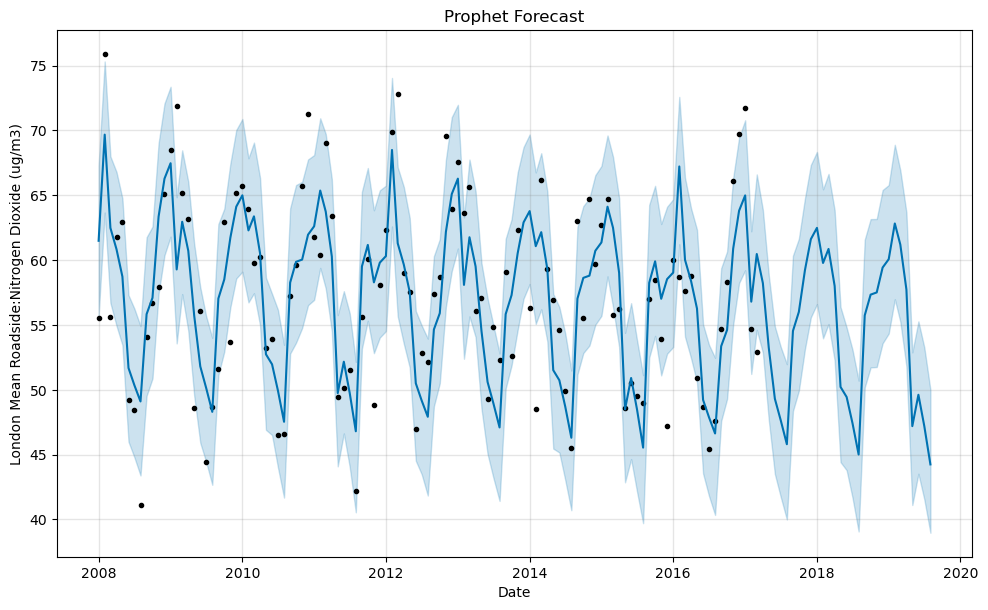

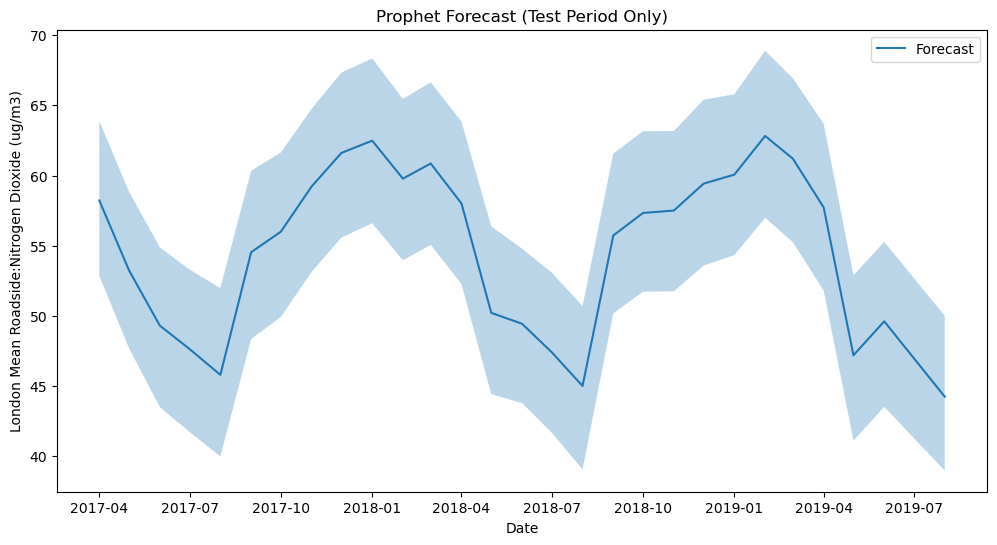

In [154]:
train_df: pd.DataFrame

# Set up the Prophet model (using default settings for now)
model: Prophet = Prophet()

# Fit the model to the training data
model.fit(train_df)

test_df: pd.DataFrame

# Calculate the number of months between the first and last dates of the test set
test_start_date = test_df['ds'].min()
test_end_date = test_df['ds'].max()
train_start_date = train_df['ds'].min()
train_end_date = train_df['ds'].max()
months_in_test_set_range: int = len(test_df)
print(f"Test set start date: {test_start_date}")
print(f"Test set end date: {test_end_date}")
print(f"Train set start date: {train_start_date}")
print(f"Train set end date: {train_end_date}")
print(f"Number of months in the test set range: {months_in_test_set_range}")

# Create a date range covering both training and test periods
all_dates = pd.date_range(start=train_start_date, end=test_end_date, freq='MS')

# Create the DataFrame for Prophet
future = pd.DataFrame({'ds': all_dates})


# Create a dataframe that extends into the future (covering the test period)
# Ensure the format is 'YYYY-MM-01'
future['ds'] = future['ds'].dt.strftime('%Y-%m-01')

# Use the model to make predictions for those future dates
forecast: pd.DataFrame = model.predict(future)

# Look at the last few predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1: Any = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('London Mean Roadside:Nitrogen Dioxide (ug/m3)')
plt.show()

# Filter forecast to test period
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]

# Plot only the forecasted period
plt.figure(figsize=(12, 6))
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast')
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], alpha=0.3)
plt.title('Prophet Forecast (Test Period Only)')
plt.xlabel('Date')
plt.ylabel('London Mean Roadside:Nitrogen Dioxide (ug/m3)')
plt.legend()
plt.show()

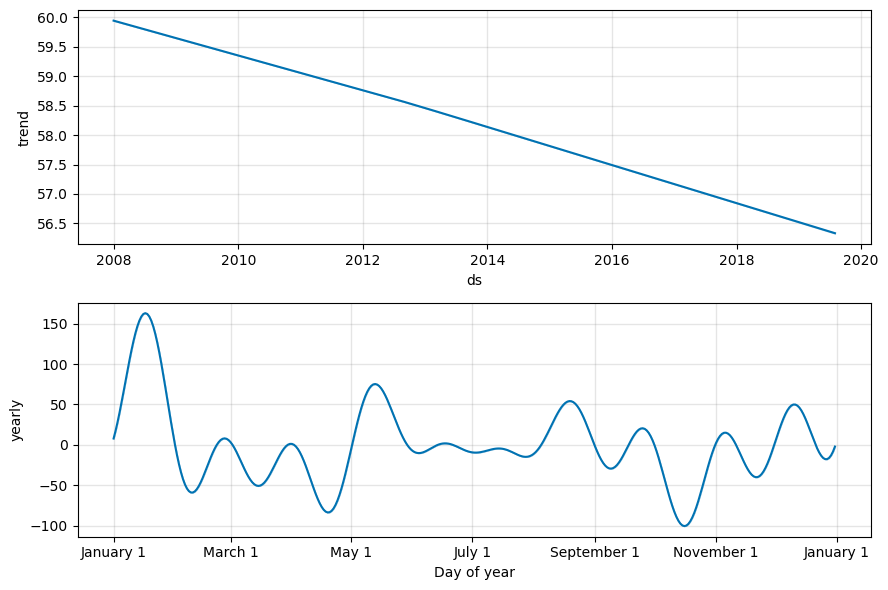

In [155]:
# Plot the trend and seasonality components
fig2: Any = model.plot_components(forecast)
plt.show()

In [156]:
forecast: pd.DataFrame
test_df: pd.DataFrame

# Filter the forecast to only the dates in the test set
forecast_test: pd.DataFrame = forecast[forecast['ds'].isin(test_df['ds'])]

# Ensure the forecast is sorted by date (just in case)
forecast_test = forecast_test.sort_values('ds')
test_df = test_df.sort_values('ds')

# Get the predicted and actual values for the test period
y_pred: np.ndarray = forecast_test['yhat'].values
y_true: np.ndarray = test_df['y'].values

# Calculate RMSE
rmse: float = (((y_pred - y_true) ** 2).mean())**0.5

# Calculate MAPE
mape: float = (abs((y_true - y_pred) / y_true).mean()) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 9.07
MAPE: 17.92%


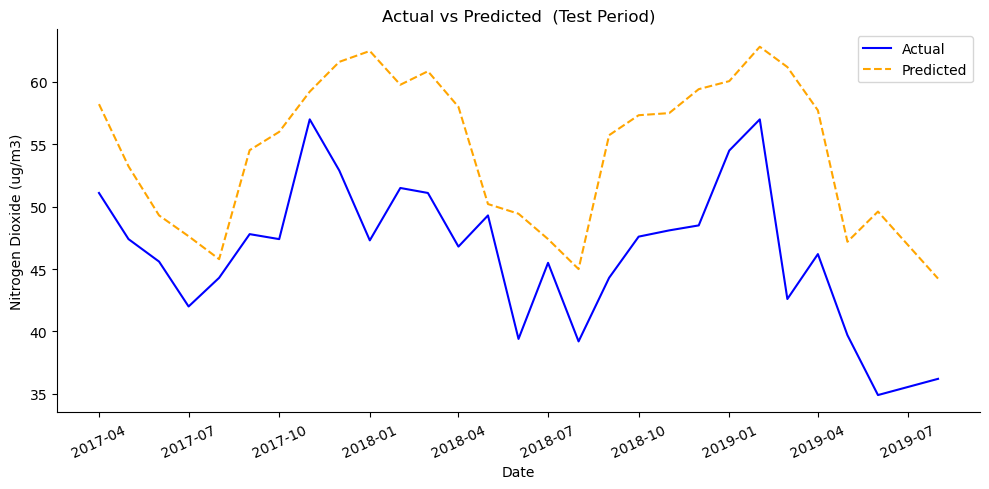

In [207]:
# Create the initial plot
g: sns.FacetGrid = sns.relplot(
    kind='line',
    data=test_df,
    x='ds',
    y='y',
    label='Actual',
    aspect=2,
    height=5,
    color='blue'
)

# Add the forecast line
_ = sns.lineplot(
    data=forecast_test,
    x='ds',
    y='yhat',
    label='Predicted',
    linestyle='--',
    ax=g.ax,
    color='orange'
)

# Customise labels and title
g.set_axis_labels("Date", "Nitrogen Dioxide (ug/m3)")
g.set(title="Actual vs Predicted  (Test Period)")

# Rotate x-axis labels
g.ax.tick_params(axis='x', rotation=25)

# Show the plot
g.figure.tight_layout();

# Cross Validation

In [164]:
initial: str ='1095 days'   # e.g., first 3 years for training
period: str ='30 days'      # make a new cutoff every month
horizon: str ='180 days'     # forecast 6 months ahead each time


# Cross validation: initial training period, period between cutoffs, forecast horizon
df_cv = cross_validation(
    model,
    initial=initial,
    period=period,
    horizon=horizon
)

  0%|          | 0/70 [00:00<?, ?it/s]11:25:40 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 1/70 [00:00<00:07,  8.92it/s]11:25:40 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing
11:25:40 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 3/70 [00:00<00:06,  9.96it/s]11:25:40 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 4/70 [00:00<00:06,  9.61it/s]11:25:40 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 5/70 [00:00<00:09,  6.90it/s]11:25:40 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing
  9%|▊         | 6/70 [00:00<00:08,  7.57it/s]11:25:40 - cmdstanpy - INFO - Chain [1] start processi

In [159]:
# Calculate metrics
df_metrics = performance_metrics(df_cv)
#df_metrics.sort_values(by='mape', ascending=True, inplace=False)
df_metrics[['horizon', 'mape']].sort_values(by='mape').head(10)

,horizon,mape
152,171 days,0.073509
92,111 days,0.073694
122,141 days,0.074073
32,51 days,0.074471
153,172 days,0.074667
154,173 days,0.075069
2,21 days,0.075227
93,112 days,0.075305
62,81 days,0.075388
123,142 days,0.075613


# Grid Search with Cross Validation

In [160]:
# Define your parameter ranges
param_grid: dict[str, list[float]] = {
    'changepoint_prior_scale': [0.01, 0.1],#, 0.5],
    'seasonality_prior_scale': [0.1, 1.0],#, 10.0],
    'changepoint_range' : [0.9, 0.7],#, 0.8]
}
param_grid

{'changepoint_prior_scale': [0.01, 0.1],
 'seasonality_prior_scale': [0.1, 1.0],
 'changepoint_range': [0.9, 0.7]}

In [161]:
# Build the list of all parameter combinations
all_params: list[dict[str, float]] = []

for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        for cpr in param_grid['changepoint_range']:
            all_params.append({
                'changepoint_prior_scale': cps,
                'seasonality_prior_scale': sps,
                'changepoint_range' : cpr
            })

all_params
df

,ds,y
0,2008-01-01,55.5
1,2008-02-01,75.9
2,2008-03-01,55.6
3,2008-04-01,61.8
4,2008-05-01,62.9
...,...,...
134,2019-03-01,42.6
135,2019-04-01,46.2
136,2019-05-01,39.7
137,2019-06-01,34.9


In [ ]:
# Fit a Prophet model for each parameter set, cross-validate and record RMSE

dfs: list[float] = []

for params in all_params:
    m: Prophet = Prophet(**params).fit(df)  # 'df' should be of type pd.DataFrame, assumed to exist beforehand
    df_cv: pd.DataFrame = cross_validation(
        m,
        initial=initial,
        period=period,
        horizon=horizon
    )

    df_p: pd.DataFrame = performance_metrics(df_cv)
    dfs.append(df_p)
    

11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/99 [00:00<?, ?it/s]11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/99 [00:00<00:07, 13.16it/s]11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/99 [00:00<00:08, 11.51it/s]11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 6/99 [00:00<00:07, 11.63it/s]11:56:09 - cmdstanpy - INFO - Cha

In [200]:
for i in range(len(dfs)):
     # Select row with minimal mape
    best_row = dfs[1].loc[dfs[1]['rmse'].idxmin()]
    print(best_row[['horizon', 'rmse']])

# Best horizon = 49

rmses: list[float] = []
# Select the RMSE at the horizon specified in cross_validation, which is 49 days
for df_p in dfs:
    rmse_horizon_49: float = df_p.loc[df_p.horizon == '49 days', 'rmse'].values[0]
    rmses.append(rmse_horizon_49)

for i in range(len(dfs)):
    print(f"Params: {all_params[i]}, RMSE: {rmses[i]}")


horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
horizon    49 days 00:00:00
rmse               5.803071
Name: 28, dtype: object
Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'changepoint_range': 0.9}, RMSE: 5.837198913307935
Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'changepoint_range': 0.7}, RMSE: 5.803071139313702
Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'changepoint_range': 0.9}, RMSE: 6.0

# XGBoost Regressor model

XGBoost MAE: 7.52
XGBoost MAPE: 0.18
XGBoost RMSE: 8.72


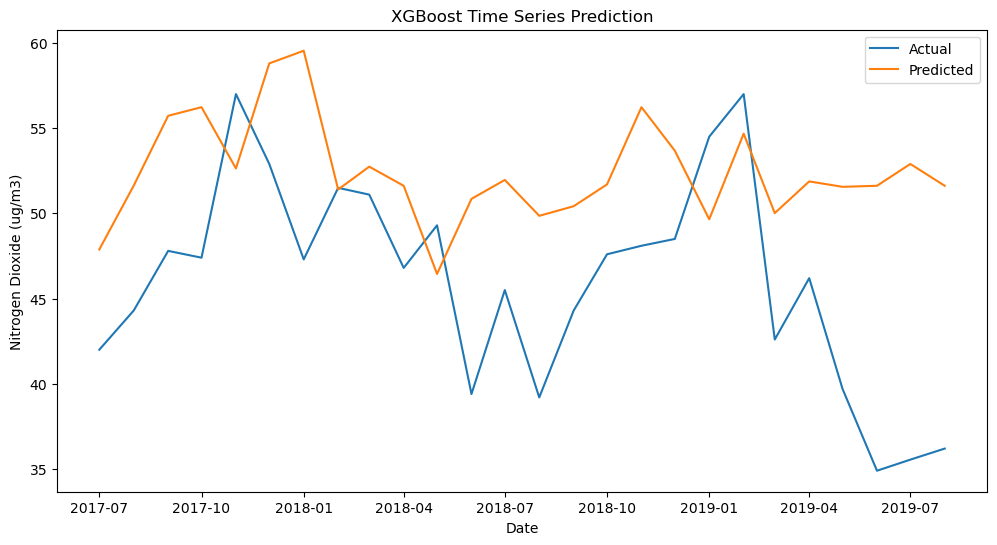

In [205]:

ts = time_series['London Mean Roadside:Nitrogen Dioxide (ug/m3)']

# Create lag features
def create_lag_features(series, lags=[1, 2, 3, 12]):
    df = pd.DataFrame(series)
    for lag in lags:
        df[f'lag_{lag}'] = series.shift(lag)
    df = df.dropna()
    return df

lags = [1, 2, 3, 12]
df_lagged = create_lag_features(ts, lags)

# Train/test split (e.g., last 20% for test)
split_idx = int(len(df_lagged) * 0.8)
train = df_lagged.iloc[:split_idx]
test = df_lagged.iloc[split_idx:]

X_train = train.drop('London Mean Roadside:Nitrogen Dioxide (ug/m3)', axis=1)
y_train = train['London Mean Roadside:Nitrogen Dioxide (ug/m3)']
X_test = test.drop('London Mean Roadside:Nitrogen Dioxide (ug/m3)', axis=1)
y_test = test['London Mean Roadside:Nitrogen Dioxide (ug/m3)']

# Fit XGBoost model
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost MAPE: {mape:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('XGBoost Time Series Prediction')
plt.xlabel('Date')
plt.ylabel('Nitrogen Dioxide (ug/m3)')
plt.legend()
plt.show()